In [1]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/akonstantinov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [54]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [55]:
articles = pd.read_csv('articles.csv')
abstracts = [abstract for abstract in articles.abstract if abstract is not np.nan]

In [65]:
# tokenize
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(abstracts))

In [66]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold =>> fewer number of bigrams.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [67]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [68]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [70]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
corpus = [txt for txt in corpus if len(txt) > 5]

In [71]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [74]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

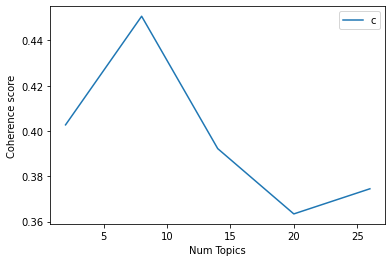

In [75]:
# Evaluete optimal num_topics. Long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=30, step=6)

# Show graph
limit=30; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

So the optimal number of topics is 7. Let's retrain the model with it.

In [76]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Let's visualize topics with `pyLDAvis`.

In [77]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.042788 -0.203367       1        1  24.197795
5      0.082863 -0.134257       2        1  23.415425
1      0.102831 -0.018146       3        1  14.494924
0     -0.172328 -0.107871       4        1  11.632638
6      0.168225  0.283581       5        1  10.446381
4      0.191644 -0.004798       6        1   9.818861
3     -0.330447  0.184858       7        1   5.993976, topic_info=             Term          Freq         Total Category  logprob  loglift
53         system  13998.000000  13998.000000  Default  30.0000  30.0000
498         field   6110.000000   6110.000000  Default  29.0000  29.0000
211         laser   7018.000000   7018.000000  Default  28.0000  28.0000
51      structure   7197.000000   7197.000000  Default  27.0000  27.0000
215       optical   6631.000000   6631.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
860   information    619.150999   3402.138254   Topic7  -5.0480   1.1106
1008         task    536.612350   1563.335855   Topic7  -5.1911   1.7451
63       analysis    618.065258   5144.698755   Topic7  -5.0497   0.6953
1723   management    502.210760   1159.948798   Topic7  -5.2573   1.9773
263           new    486.812269   3599.596576   Topic7  -5.2885   0.8137

[393 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
528       3  0.998927  absorption
128       4  0.999213      access
490       1  0.999622    accuracy
447       1  0.999438    accurate
3         3  0.919376      active
...     ...       ...         ...
660       5  0.999148   waveguide
229       3  0.860260  wavelength
229       5  0.139151  wavelength
5647      7  0.996730    workshop
201       4  0.999209        year

[600 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 2, 1, 7, 5, 4])

Let's name each topic according to its most prominent words:

1. **Data science**;

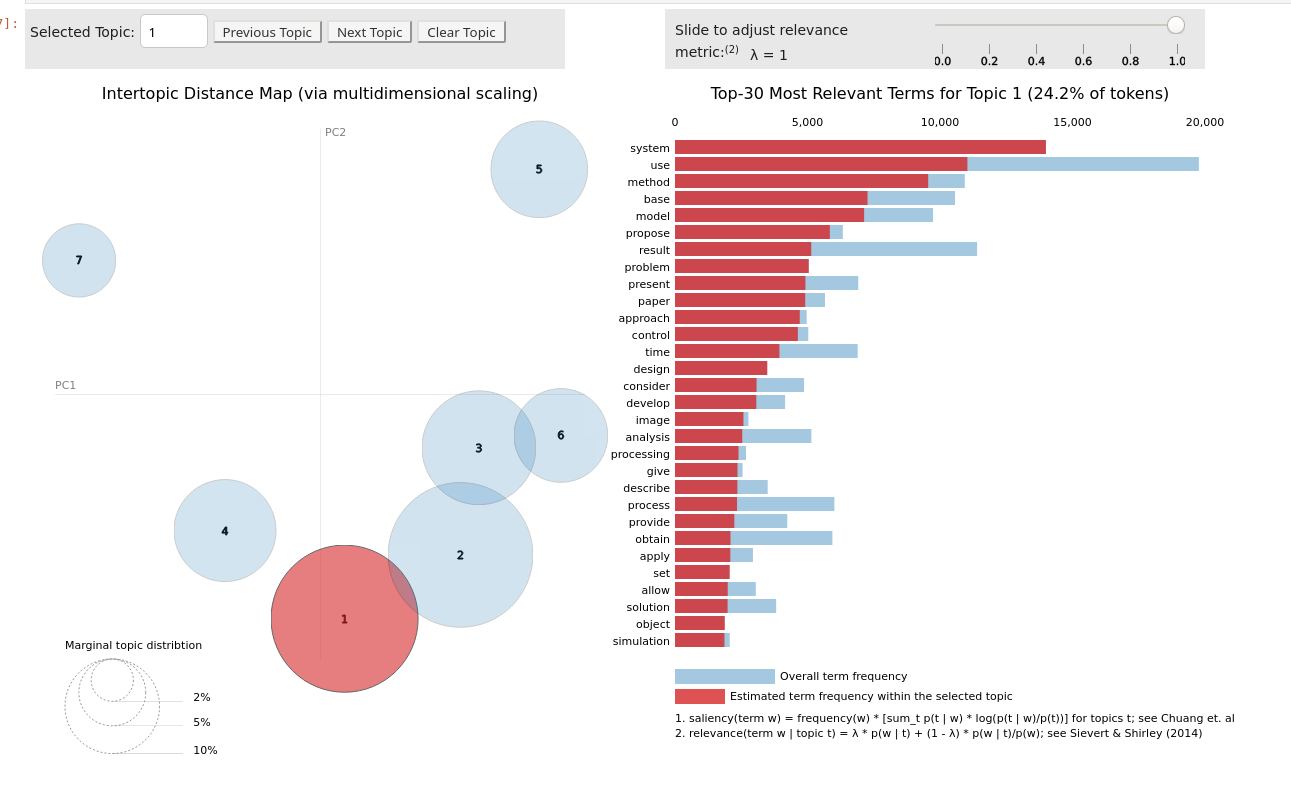

2. **Looks like something between data science and physics**;

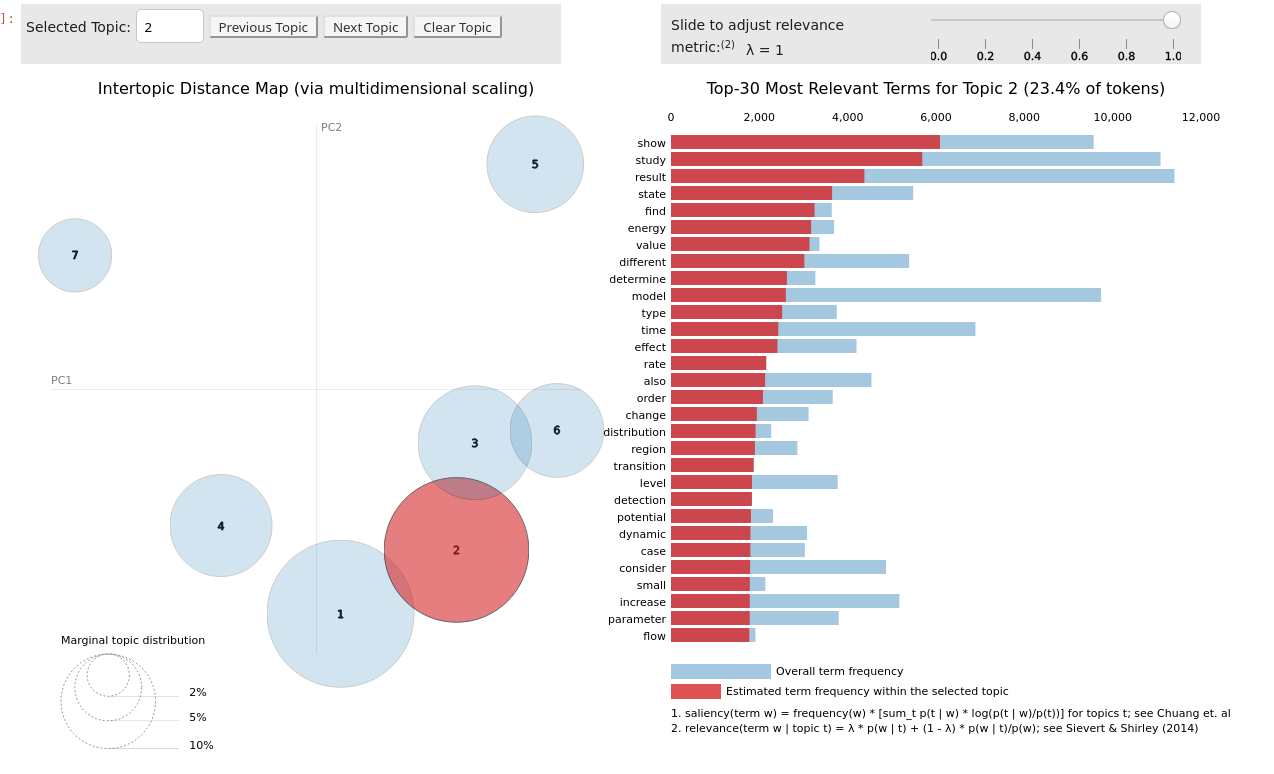

3. **Physics (in general)**;

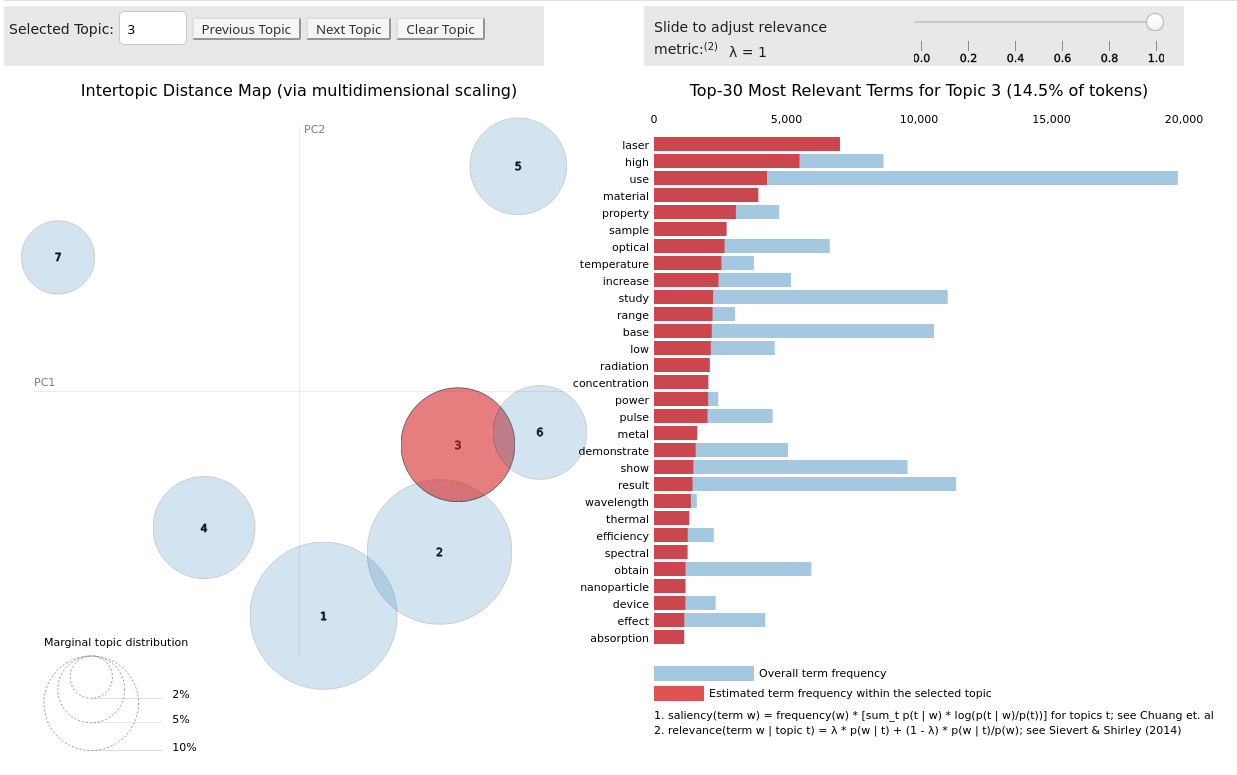

4. **Computer science**;

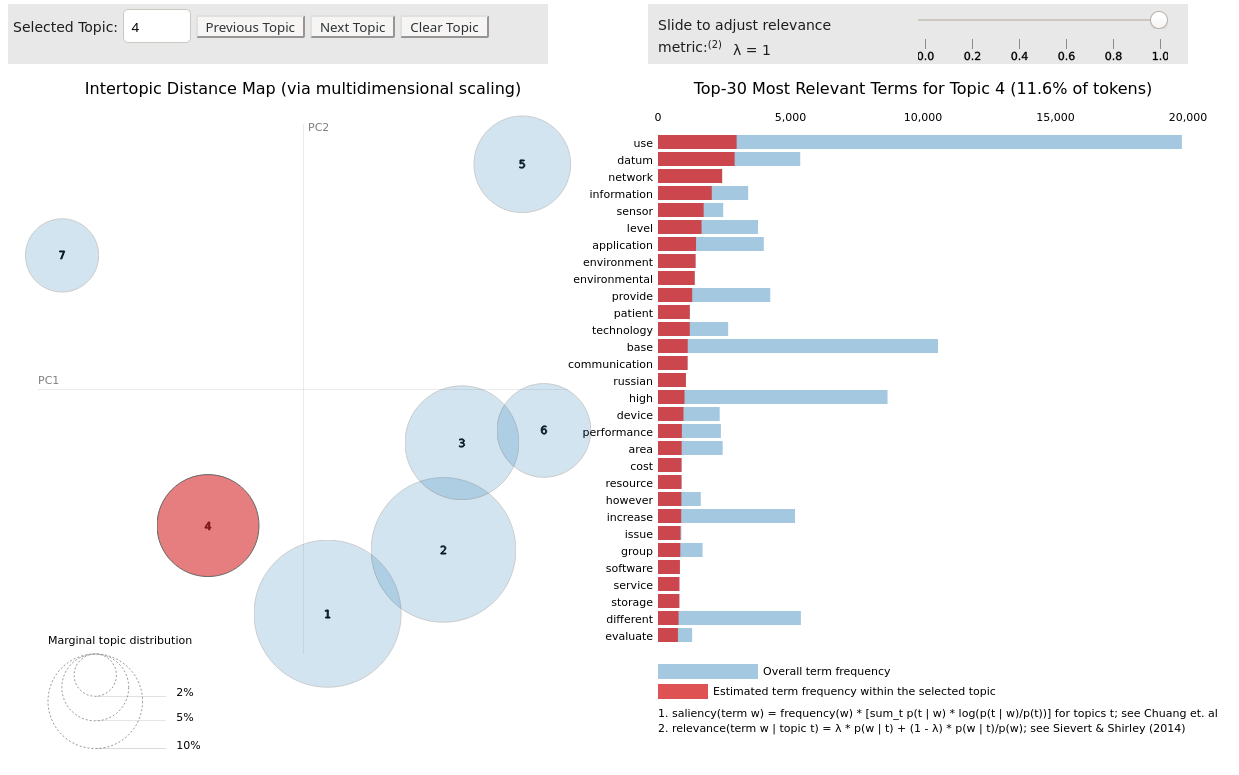

5. **Photonics**;

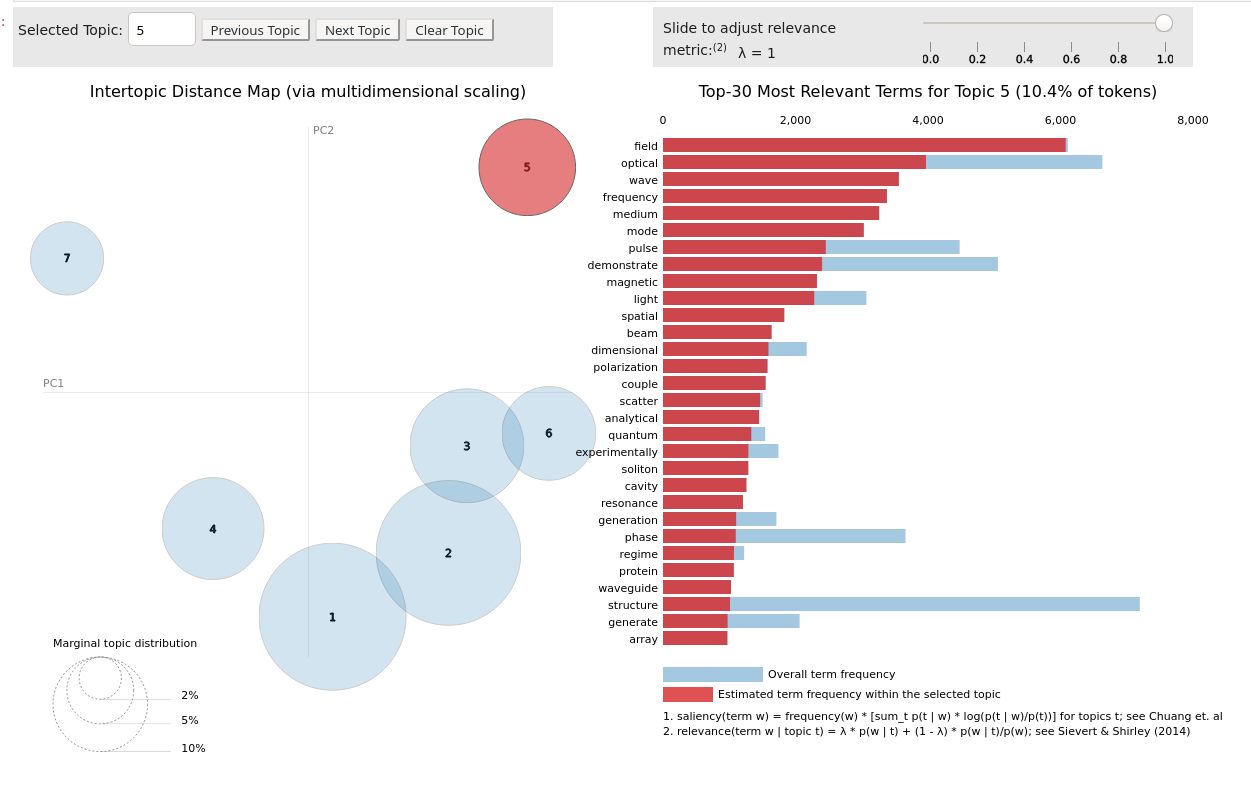

6. **Materials physics**;

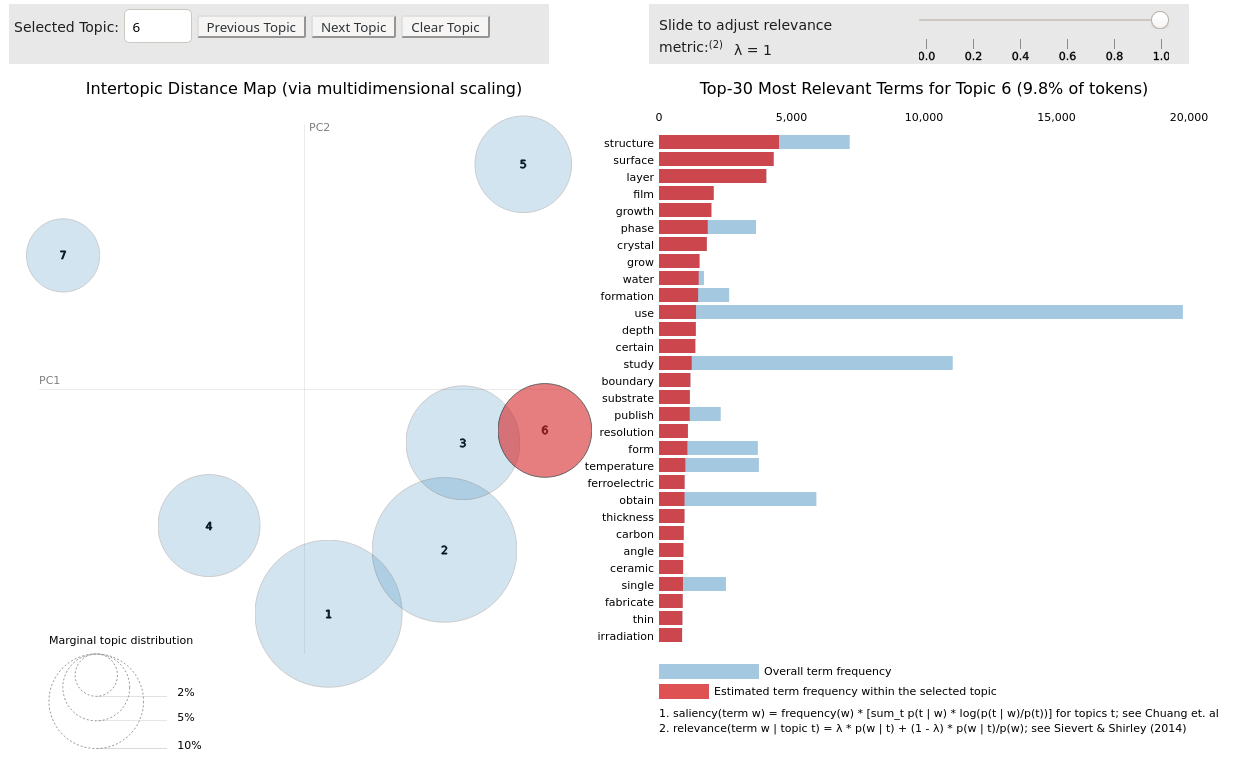

7. **Generic words that are present in every paper**.

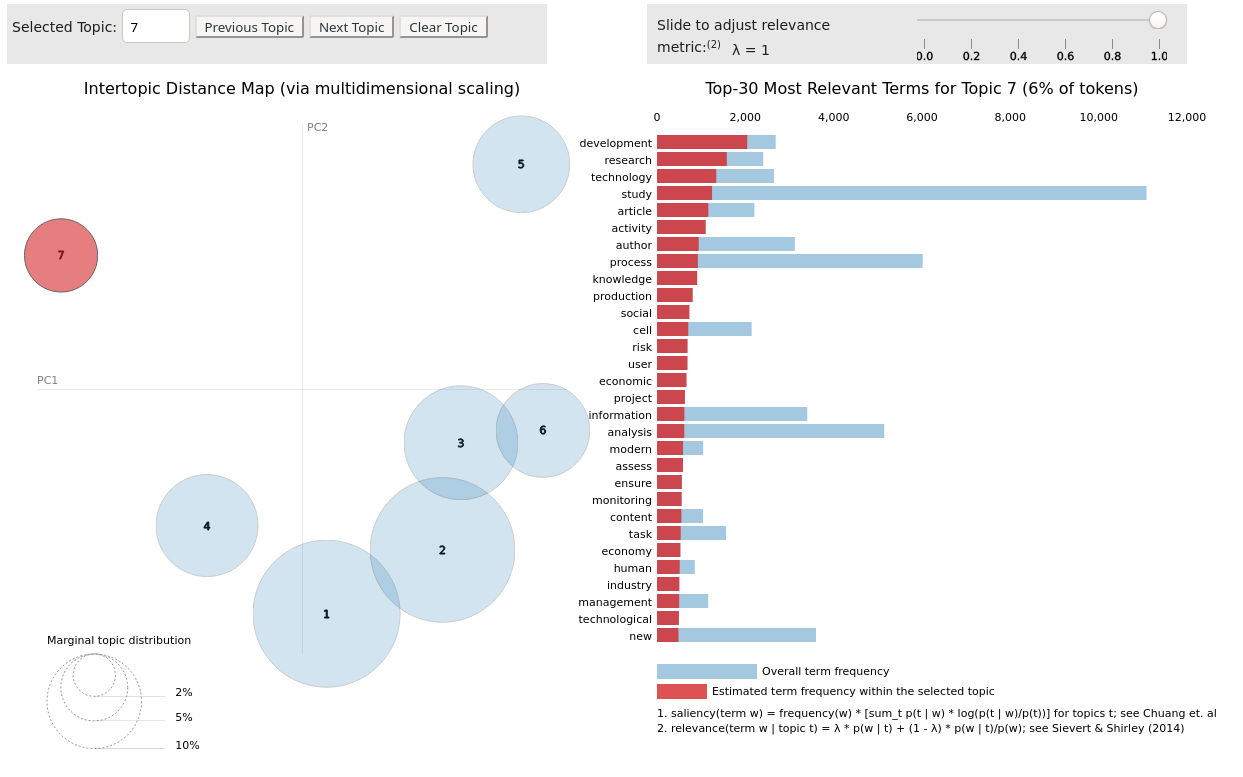